# This notebooks only contains the experimental codes for var-speed condition

In [51]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run Animal_Tags.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
%run UtilityTools.ipynb
os.chdir(CWD)

defaultParam={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }
param=defaultParam

### trimmed mean function
averaging after removing outliers (-+3 SDs)

In [2]:
def trimmed_mean(x):
    if len(x)<50:
        return np.nanmean(x)
    SD=np.nanstd(x)
    MEAN=np.nanmean(x)
    out=scipy.stats.tmean(x, limits=(MEAN-3*SD,MEAN+3*SD), inclusive=(False, False), axis=None)
    return out

# stuff

In [36]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':['10','var'],
     'Speed':['var'],
     'Tag':'Control-Late-var'
              }
animalList=batch_get_animal_list(root,AnimalProfile)

In [39]:
animalList

['Rat077',
 'Rat078',
 'Rat084',
 'Rat085',
 'Rat088',
 'Rat091',
 'Rat095',
 'Rat096',
 'Rat098',
 'Rat103',
 'Rat104',
 'Rat110',
 'Rat113',
 'Rat120']

# **effect of HiPenalty Condition**

In [116]:
def plot_goal_time_change(root, Profiles, N, GT, badAnimals, TaskParamToPlot, wspace, gs, fig):
    """
    gs could be either gridSpec or a list of axes with 
    """
    if isinstance(gs,matplotlib.gridspec.SubplotSpec):
        gssub = gs.subgridspec(1, len(Profiles)-1,wspace=wspace)
        axes=[]
    else:
        gssub=False
        axes=gs
    for eventN in range(len(N)-1):
        #getting the data
        _,SessionDict=event_detect(root, Profiles[eventN], Profiles[eventN+1], badAnimals=badAnimals)

        Results,nSessionPre,nSessionPost=event_statistic(root,
                                                         SessionDict,
                                                         parameter=param,
                                                         redo=False,
                                                         TaskParamToPlot=[TaskParamToPlot])
        
        assert N[eventN]<nSessionPre and N[eventN+1]<nSessionPost,\
               f"fewer sessions available than requested:{Profiles[eventN]['Tag']}"

        data=np.array(list(Results[TaskParamToPlot].values()))
        data=data[:,
                  nSessionPre-N[eventN] : nSessionPre+N[eventN+1]
                 ]

        y=np.nanpercentile(data,50,axis=0)
        yerr=np.nanpercentile(data,(25,75),axis=0)

        #getting the axes
        if gssub:
            ax=fig.add_subplot(gssub[0, eventN])
        else:
            ax=axes[eventN]

        #plotting
        xLabel=list(range(-N[eventN],N[eventN+1]+1))
        xLabel.remove(0)
        ax.errorbar(xLabel,y,yerr=abs(yerr-y), ecolor='k', fmt='k-o',
                    markersize=2, elinewidth=1, linewidth=1, markerfacecolor='w',zorder=1)
#         ax.plot([xLabel[0],-1,1,xLabel[-1]],[GT[eventN],GT[eventN],GT[eventN+1],GT[eventN+1]],
#                 'm--',lw=1, zorder=-5)



        if xLabel[0]<=-10 or xLabel[-1]>=10:
            newLabel=[label for label in xLabel if label%10==0]
#             newLabel.extend([1,-1])
#             newLabel.extend([xLabel[0],xLabel[-1]])
            newLabel=list(set(newLabel))
            newLabel.sort()

        ax.set_xlim([xLabel[0]-1,xLabel[-1]+1])
        ax.set_xticks(newLabel)
#         ax.spines['bottom'].set_bounds(xLabel[0],xLabel[-1])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_ylabel(TaskParamToPlot)
#         ax.set_ylim([0,10])
#         ax.set_yticks(list(set(GT)))
        ax.vlines(x=0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1]*.9, color='k',linestyles='--',lw=.8)

        if gssub:
            axes.append(ax)
#     axes[1].set_xlabel('Session relative to goal time change')
#     axes[0].spines['left'].set_position(('axes',-.05))
    for ax in axes[1:]:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)

    return tuple(axes)

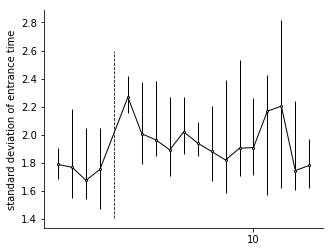

In [118]:
if "__file__" not in dir():

    profile1={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control-BackTo10']
              }
    profile2={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'var',
              'Tag':['Control-Late-var']
              }

    #number of sessions to plot
    N=[1,14]
    #goal times
    GT=[7,7]
    badAnimals=['RatBAD']
    TaskParamToPlot="percentile entrance time"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    gs=fig.add_gridspec(1,1)[0]
    
    axes=plot_goal_time_change(root, Profiles, N, GT, badAnimals, TaskParamToPlot, wspace, gs, fig)
#     axes=plot_goal_time_change(root, Profiles, N, GT, badAnimals,
#                                TaskParamToPlot='standard deviation of entrance time', wspace=wspace, gs=axes, fig=fig)
    
#     axes[0].set_ylabel('Entrance Times (s)')

---

**Plot probability of correct trial given Treadmill Speeds**

In [150]:
def prob_correct_given_distance(animalList, profile, SessionRange, GT, spdBins):
    def entrance_time(data):
        data.entranceTime[data.entranceTime==data.maxTrialDuration]=0
        return data.entranceTime
    def treadmill_speed(data):
        return data.treadmillSpeed

    param=[treadmill_speed,entrance_time]

    et=[]
    spd=[]
    for animal in animalList:
        data=data_fetch(root,animal,profile, param, NbSession=100)
        spd.append(data[param[0].__name__][SessionRange[0]:SessionRange[-1]])
        et.append(data[param[1].__name__][SessionRange[0]:SessionRange[-1]])
        

    corrData=dict.fromkeys(animalList,None)
    spdData=dict.fromkeys(animalList,None)
    for i,animal in enumerate(animalList):
        corrData[animal]=[]
        spdData[animal] =[]
        for j in range(len(et[i])):
            if len(et[i][j])==len(spd[i][j]):
                corrData[animal].extend(np.logical_and(et[i][j]>min(GT),et[i][j]<max(GT)))
                spdData[animal].extend(spd[i][j])

    Panimal=np.ones((len(spdBins)-1,len(animalList)))*np.nan
    for col,animal in enumerate(animalList):
        correct =np.array(corrData[animal])
        speed=np.array(spdData[animal])
        for i,(loBin,hiBin) in enumerate(zip(spdBins[:-1],spdBins[1:])):
            signal=correct[np.logical_and(speed>=loBin,speed<hiBin)]
            if len(signal)> 10:
                Panimal[i,col]= sum(signal)/len(signal)

    Ptotal=np.ones((len(spdBins)-1,))*np.nan
    correct=[]
    speed=[]
    for col,animal in enumerate(animalList):
        correct.extend(corrData[animal])
        speed.extend(spdData[animal])
    correct=np.array(correct)
    speed=np.array(speed)
    for i,(loBin,hiBin) in enumerate(zip(spdBins[:-1],spdBins[1:])):
        signal=correct[np.logical_and(speed>=loBin,speed<hiBin)]
        if len(signal)> 10:
            Ptotal[i]= sum(signal)/len(signal)
    
    return Ptotal, Panimal


def plot_cond_prob_correct(ax, animalList, profile, SessionRange, GT, spdBins, **kwargs):
    Ptotal, _=prob_correct_given_distance(animalList,
                                                profile,
                                                SessionRange,
                                                GT,
                                                spdBins)
    
    binSize=spdBins[1]-spdBins[0]    
    
    ax.plot(np.array(spdBins[:-1])+binSize/2, Ptotal, **kwargs)

    
    spd,data=np.array(spdBins[:-1])+binSize/2, Ptotal
    ax.vlines(spd[data.argmax()], -10,data.max(),alpha=.25,linewidth=.5,color='k')
    ax.set_xticks([spdBins[0],spd[data.argmax()],spdBins[-1]])

    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(spdBins[0],spdBins[-1])
    ax.spines['left'].set_bounds(0,1)
    ax.set_ylim([-.02,1])
    ax.set_yticks([0,.5,1])
    ax.set_yticklabels([0,'',1])
    ax.set_xlim([spdBins[0]-1,spdBins[-1]])
    ax.set_xticks([spdBins[0],spd[data.argmax()],spdBins[-1]])
    ax.set_xlabel('Speed ($cm.s^{-1}$)')
    ax.set_ylabel(f"Probability")
    ax.yaxis.set_label_coords(-0.04,0.5)
    
    return Ptotal

def add_legend_to_cond_prob_plot(ax, colors, labels):
    lines=[]
    for color, label in zip(colors,labels):
        lines.append(matplotlib.lines.Line2D([], [], color=color,label=label))
    
    leg=ax.legend(handles=lines, title="",title_fontsize=6, handletextpad=.6,
                  bbox_to_anchor=(0, 1),loc=2, ncol=1, fontsize='xx-small', frameon=False)
    

array([0.51648352, 0.64423077, 0.8       , 0.67924528, 0.69879518,
       0.66233766, 0.53191489, 0.47916667, 0.42696629, 0.35869565,
       0.26315789, 0.25806452, 0.21111111, 0.24137931, 0.18390805,
       0.17857143, 0.14141414, 0.1627907 , 0.12765957, 0.17333333,
       0.08571429, 0.03571429, 0.2       , 0.10344828, 0.03571429])

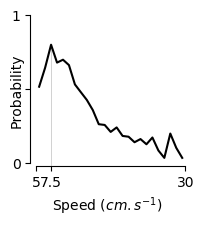

In [152]:
if "__file__" not in dir():
    AnimalProfile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['10','var'],
         'Speed':['var'],
         'Tag':'Control-Late-var'
                  }
    animalList=batch_get_animal_list(root,AnimalProfile)

    Y1,Y2=[0,90]
    SessionRange=[0,1]
    spdBins=range(5,31,1)
    GTrange=(7,15)
    labels=[f'$ P ({GTrange[0]} < ET < {GTrange[1]})$']
    plt.close('all')
    fig=plt.figure(figsize=(2,2),dpi=100)
    ax=fig.add_subplot(111)

    
    plot_cond_prob_correct(ax, animalList, AnimalProfile, SessionRange, GTrange, spdBins, color='k',label=labels[0])
    plt.show()


### Get the mean speed for variable speed sessions

In [ ]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':['10','var'],
     'Speed':['var'],
     'Tag':'Control'
              }
SESSION_LIMIT=100


In [ ]:
animalList=batch_get_animal_list(root,AnimalProfile)
try:
    animalList.remove('Rat106')
except:pass
data=[]
sessionN=0
for animal in  animalList:
    sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
    if SESSION_LIMIT >0:
        tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
    else:
        tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]
    for session in tmp:
        filePath=os.path.join(root,animal,'Experiments',session,session)
        varSpd=read_in_file(filePath,paramName=' ',extension='.variablespeed',valueType=float)
        if isinstance(varSpd,np.ndarray):
            if max(varSpd)>40:print(session)
            data.extend(varSpd.tolist())
            sessionN+=1

print('good sessions:',sessionN)
print('session limit:',SESSION_LIMIT)
print('# of trials:',len(data))
data=np.array(data)
plt.boxplot(data)
plt.ylabel('Speed (cm/s)')
plt.title('variable speeds')
plt.figure();
plt.hist(data,bins=[0,5,10,15,20,25,30,max(data)],width=4.8)
plt.show()

### P(correct trial | slow/fast speed trial) in var speed condition

+trial: 1369
-trial: 0


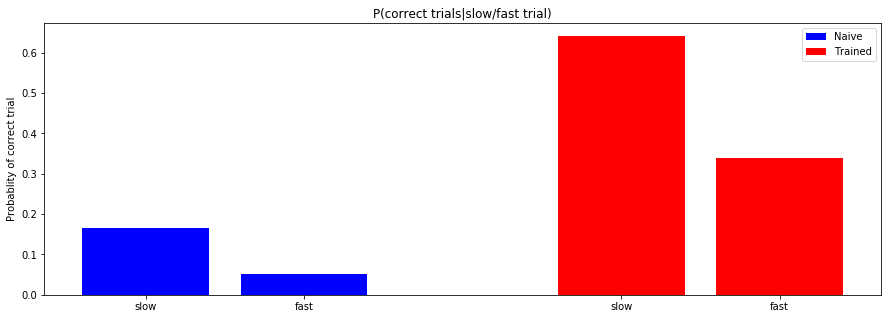

In [119]:
def P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE):
    animalList=batch_get_animal_list(root,AnimalProfile)
    N=0
    goodN=0
    countN=0
    countP=0
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]
            tmp=[tmp[-1]]
        for session in tmp:
            picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
            filePath=os.path.join(root,animal,'Experiments',session,session)
            with open(picklePath,'rb') as f:
                data=pickle.load(f)
            try:
                spd0=read_in_file(filePath,paramName=' ',extension='.variablespeed',valueType=float)
                ET0=np.array(data['entranceTime'])
            except:
                spd0=[]
                ET0=[0,0]
            if len(ET0)==len(spd0):
                goodTrial=np.logical_and(spd0 >= SPEED_RANGE[0], spd0 <SPEED_RANGE[-1])
                N+=np.sum(goodTrial)
                goodN+=np.sum(np.logical_and(ET0[goodTrial]>=7, ET0[goodTrial]<15))
                countP+=len(goodTrial)
            else:
                countN+=1
    print('+trial:',countP)
    print('-trial:',countN)
    return goodN,N    


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     #'initialSpeed':['var'],
#      'Speed':['var'],
     'Tag':'Control-Early-var'
              }


SESSION_LIMIT=10
SPEED_RANGE        =[[7.5,12.5],[25,30]]
plt.figure(figsize=[15,5])
goodN0S,N0S=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[0])
goodN0F,N0F=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[1])
SESSION_LIMIT=-SESSION_LIMIT
goodN1S,N1S=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[0])
goodN1F,N1F=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[1])
SESSION_LIMIT=-SESSION_LIMIT

plt.bar([0,1],[goodN0S/N0S,goodN0F/N0F],color='b',label='Naive')
plt.bar([3,4],[goodN1S/N1S,goodN1F/N1F],color='r',label='Trained')
plt.xticks([0,1,3,4],['slow','fast','slow','fast'])
plt.legend();
plt.title('P(correct trials|slow/fast trial)');
plt.ylabel('Probablity of correct trial');

### DLS lesion effect on variable speed

In [ ]:
profile1={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':'Control'
         }
profile2={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':['10'],
         'Tag':['Early-Lesion_DLS']
         }
animalList1=batch_get_animal_list(root,profile1)
animalList2=batch_get_animal_list(root,profile2)
#del animalList2[animalList2.index('Rat081')]
#animalList2=['Rat118', 'Rat119', 'Rat133', 'Rat134']
animalList2= [ 'Rat097', 'Rat099', 'Rat100', 'Rat114', 'Rat116']
groups={
    "group1":(cm.Greys,"black",animalList1,profile1),
    "group2":(cm.Reds ,"red"  ,animalList2,profile2),
    }
TaskParamToPlot=["% good trials",'% good trials on last 40',"percentile entrance time",
            "Forward Speed Vs TreadmillSpeed","Tortuosity","standard deviation of entrance time","Trajectory Correlation"]
TaskParamToPlot=["Entropy","Mean Pairwise RMSE"]
stop_dayPlot =10
fullLegend=False
print(animalList1,animalList2)

allResults,colors,colorGroup=plot_mean_subgroup_animal(root,groups,redo=False,stop_dayPlot=stop_dayPlot,TaskParamToPlot=TaskParamToPlot,fullLegend=fullLegend)


In [ ]:
TaskParam="Mean Pairwise RMSE"
Days=[0,1,2,3,4]
X=[1,1.5]
#======================================
fig=plt.figure()
plt.ylabel(TaskParam)
for i,Day in enumerate(Days):
    ax = plt.subplot(1,len(Days),i+1)
    ax.set_yticks([])
    if i==0:
        ax.set_ylabel(TaskParam)
        ax.set_yticks([0,50,100])
        
    G1=[]
    G2=[]
    for animal in allResults[TaskParam]['group1'].keys():
        G1.append(allResults[TaskParam]['group1'][animal][Day])
    for animal in allResults[TaskParam]['group2'].keys():
        G2.append(allResults[TaskParam]['group2'][animal][Day])

    G1=np.array(G1)
    G2=np.array(G2)
    res=permtest(G2,G1, iterN=10000)
    ax.boxplot([G1[~np.isnan(G1)],G2[~np.isnan(G2)]],sym='',positions=X)
    xdist1=np.random.normal(loc=X[0],scale=.03,size=len(G1))
    ax.scatter(xdist1,G1,c='b',marker='o',alpha=0.4,label=profile1['Tag'][0],s=10)
    xdist2=np.random.normal(loc=X[1],scale=.03,size=len(G2))
    ax.scatter(xdist2,G2,c='r',marker='o',alpha=0.4,label=profile2['Tag'][0],s=10)
    ax.title.set_text('p='+str(res.p_val[0])[:6])
    ax.set_xticks([np.mean(X)])
    ax.set_xticklabels(['Day'+str(i+1)])
    ax.set_ylim([0,1])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig(filename='/home/david/Downloads/AA.pdf',format='pdf',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

### Separating trajectories baed on speed

In [ ]:
session='Rat159_2017_09_20_14_41'
data=Data(root,session[:6],session,redoPreprocess=False)
a=read_in_file(data,'',extension=".variablespeed",exclude=None,valueType=float)


### forward speed vs treadmill speed

In [ ]:
def mean_forwardSpeed(data,smoothSpeed=0.3):
    '''
    plot mean forwardSpeed 
    '''
    ValuesSessionRatio=[]
    treadmillSpeed =read_in_file(data,'',extension=".variablespeed",exclude=None,valueType=float)
    cs=data.cameraSamplingRate
    ValuesSessionRatio=[]
    for trial in data.trials:
        tr=treadmillSpeed[trial]
        position,_ =get_position_treadmillOn(data,trial)
        speed= tr - np.diff(position)*cs 
        speed[speed<(-tr)]=-tr
        speed=smooth(speed,smoothSpeed*cs)
        MeanSpeed=np.nanmean(speed[speed>tr])
        ValuesSessionRatio.append(MeanSpeed)
        
    return ValuesSessionRatio,treadmillSpeed

def plot_speed_correlation(root,animalList,SESSION_LIMIT):
    ForwardSpd=[]
    TreadmillSpd=[]
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]

        for session in tmp:
            data=Data(root,session[:6],session,redoPreprocess=False)
            forSpd,tSpd=mean_forwardSpeed(data,smoothSpeed=0.3)
            ForwardSpd.extend(forSpd)
            TreadmillSpd.extend(tSpd)
    ForwardSpd=np.array(ForwardSpd)
    TreadmillSpd=np.array(TreadmillSpd)
    #plotting
    plt.scatter(TreadmillSpd,ForwardSpd)
    plt.xlabel("Treadmill Speed")
    plt.ylabel("Forward Overspeed")
    
    binSig=np.logical_or(np.isnan(TreadmillSpd),np.isnan(ForwardSpd))
    binSig=np.logical_not(binSig)
#     r=np.corrcoef(TreadmillSpd[binSig],ForwardSpd[binSig])[0,1]
#     p=scipy.stats.pearsonr(TreadmillSpd[binSig],ForwardSpd[binSig])[1]
    plt.title('r='+str(r)+' p='+str(p))
    return TreadmillSpd,ForwardSpd

In [ ]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     #'initialSpeed':['10'],
     #'Speed':['10'],
     'Tag':'Early-Lesion_DLS-Early-var'
              }
animalList=batch_get_animal_list(root,AnimalProfile)
#animalList=['Rat145']
SESSION_LIMIT=-5
plt.figure(figsize=(10,10))

TreadmillSpd,ForwardSpd=plot_speed_correlation(root,animalList,SESSION_LIMIT);

In [ ]:
session='Rat147_2017_11_06_11_08'
data=Data(root,session[:6],session,redoPreprocess=False)
# treadmillSpeed =read_in_file(data,' ',extension=".variablespeed",exclude=None,valueType=float)
# treadmillSpeed

In [ ]:
i=80

plt.plot(data.timeTreadmill[i],data.position[i])
plt.plot(data.entranceTime[i]-1,data.position[i][int(data.entranceTime[i]*25)],'r*')
print(data.entranceTime[i])